Stance Detection

In [12]:
!pip install flair
!pip install pysentimiento
!pip install sentence_splitter
!pip install tensorflow
!python -m spacy download es_core_news_sm


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 81.8 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [13]:
import pandas as pd
import numpy as np
from tqdm import tqdm

In [14]:
# Entity detection (Milei/Massa)

from flair.data import Sentence
from flair.models import SequenceTagger

tagger = SequenceTagger.load("flair/ner-spanish-large")

def search_milei_massa(text):

    # make example sentence
    sentence = Sentence(text)

    # predict NER tags
    tagger.predict(sentence)

    entities = []

    # iterate over entities and print
    for entity in sentence.get_spans('ner'):
        entities.append(entity.text.lower())

    return entities

2024-03-06 19:45:11,319 SequenceTagger predicts: Dictionary with 20 tags: <unk>, O, S-LOC, S-ORG, B-PER, I-PER, E-PER, S-MISC, B-ORG, E-ORG, S-PER, I-ORG, B-LOC, E-LOC, B-MISC, E-MISC, I-MISC, I-LOC, <START>, <STOP>


Sentiment Analysis with Pysentimento (First Model) and Political Tendence

In [15]:
from pysentimiento import create_analyzer
from sentence_splitter import split_text_into_sentences


def get_sentiment(text):

    analyzer = create_analyzer(task="sentiment", lang="es")

    return analyzer.predict(text)


def get_output_sign(output):
    if output.output == "POS":
        return 1
    if output.output == "NEG":
        return -1
    else:
        return 0.0




Model Evaluations

In [16]:


def political_tendence(row):

    tweet_text = row.text
    #entities = search_milei_massa(tweet_text)


    if ("massa" in tweet_text.lower()) and ("milei" in tweet_text.lower()):

        sentences = row.sentences
        n = 0
        score = 0

        for sentence in sentences:
            n += 1
            names = search_milei_massa(sentence)

            if ("massa" in tweet_text.lower()) and ("milei" in tweet_text.lower()) or len(names) == 0:
                score += np.random.uniform(-1, 1)
            else:

                if 'milei' in names:

                    output = get_sentiment(sentence)
                    score += output.probas[output.output]*get_output_sign(output)

                elif 'massa' in names:

                    output = get_sentiment(sentence)
                    score -= output.probas[output.output]*get_output_sign(output)

        if n == 0: n = 1
        return score /n

    elif ("massa" in tweet_text.lower()):

        output = get_sentiment(tweet_text)
        return -output.probas[output.output]*get_output_sign(output)

    elif ("milei" in tweet_text.lower()):

        output = get_sentiment(tweet_text)
        return output.probas[output.output]*get_output_sign(output)


    else: return 0


Sentiment Analysis with Distillbert Multilingual (First Model) and Political Tendence

In [17]:
from transformers import pipeline
import torch

def get_sentiment2(text):

    if torch.cuda.is_available():
        # GPU
        device = 0

    else:
        # CPU
        device = -1

    analyzer = pipeline(
        model="lxyuan/distilbert-base-multilingual-cased-sentiments-student",
        top_k=1,
        device = device
    )
    return analyzer(text)


output = get_sentiment2("Milei es el peor") # Example: Milei is the worst
print(output[0][0]['label'])




negative


In [18]:
def get_output_sign2(output):
    # Find the dictionary with the highest score
    label = output[0][0]["label"]
    score = output[0][0]["score"]
    # Return the score with proper sign
    if label == 'positive':
        return score
    elif label == 'negative':
        return -score
    else:
        return 0

get_output_sign2(output)

-0.9528407454490662

In [19]:


def political_tendence2(row):

    tweet_text = row.text


    if ("massa" in tweet_text.lower()) and ("milei" in tweet_text.lower()):

        sentences = row.sentences
        n = 0
        score = 0

        for sentence in sentences:
            n += 1
            names = search_milei_massa(sentence)
            sen_low = sentence.lower()
            if ("massa" in sen_low) and ("milei" in sen_low) or len(names) == 0:
                score += np.random.uniform(-1, 1)
            else:

                if 'milei' in sen_low:

                    output = get_sentiment2(sentence)
                    score += get_output_sign2(output)

                elif 'massa' in sen_low:

                    output = get_sentiment2(sentence)
                    score -= get_output_sign2(output)

        if n == 0: n = 1
        return score /n

    elif ("massa" in tweet_text.lower()):

        output = get_sentiment2(tweet_text)
        return -get_output_sign2(output)

    elif ("milei" in tweet_text.lower()):

        output = get_sentiment2(tweet_text)
        return get_output_sign2(output)


    else: return 0


Example run for some 200 tweets

In [ ]:

results = []
ids = []
df = pd.read_csv("milei_massa_data_sentence.csv")
file_path = '/political_tendence.csv'

df_in = df.iloc[:200]

for i, row in tqdm(df_in.iterrows(), total=len(df_in)):
    try:
        score = political_tendence2(row)

        # Append id and score to lists
        ids.append(row['id'])
        if score > 0:
            results.append(1)
        elif score < 0:
            results.append(0)
        else:
            results.append(2)

        # Save intermediate results
        if i % 500 == 0 and i > 5:
            df_temp = pd.DataFrame({'id': ids, 'score': results})
            df_temp.to_csv(file_path, index=False, header=True)

    except Exception as e:
        print(f"Error occurred during processing row {i}: {e}")
        results.append(3)

# Create DataFrame with ids and results and save it to CSV
df_final = pd.DataFrame({'id': ids, 'score': results})
df_final.to_csv(file_path, index=False, header=True)

Run code with small test set

In [38]:
from sklearn.preprocessing import LabelEncoder
df_test = pd.read_csv("df_test_sentence.csv")
df_filtered = df_test[df_test['pro'] != 'none'] # Drop unkown/neutral tweets

# Encode labels
label_encoder = LabelEncoder()
label_encoder.classes_ = ['pro massa', 'pro milei']
df_filtered['encoded_labels'] = label_encoder.fit_transform(df_filtered['pro'])

<ipython-input-38-62d2f77ca130>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['encoded_labels'] = label_encoder.fit_transform(df_filtered['pro'])


In [39]:
import random


results = []
file_path = 'political_tendence_test1.csv'
# Initialize tqdm with the total number of rows in your dataframe
for i, row in tqdm(df_filtered.iterrows(), total=len(df_filtered)):
    score = political_tendence(row)

    # Save intermediate results

    if i%500 == 0 and i > 5:
      df2 = pd.DataFrame(results)
      df2.to_csv(file_path, index=False, header=True)

    # Assign political tendence

    if score > 0:
        results.append(1)
    elif score < 0:
        results.append(0)
    else:
        results.append(random.choice([0, 1]))

df2 = pd.DataFrame(results)
df2.to_csv(file_path, index=False, header=True)

 57%|█████▋    | 73/127 [01:49<01:11,  1.33s/it]

2024-03-06 20:44:30,339 Warning: An empty Sentence was created! Are there empty strings in your dataset?


100%|██████████| 127/127 [03:22<00:00,  1.59s/it]


In [42]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


# Calculate evaluation metrics
accuracy = accuracy_score(df_filtered['encoded_labels'], results)
precision = precision_score(df_filtered['encoded_labels'], results, average='weighted', zero_division=0)
recall = recall_score(df_filtered['encoded_labels'], results, average='weighted', zero_division=0)
f1 = f1_score(df_filtered['encoded_labels'], results, average='weighted', zero_division=0)

# Print metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

Accuracy: 0.4330708661417323
Precision: 0.6492969628796401
Recall: 0.4330708661417323
F1-score: 0.3565982258546796


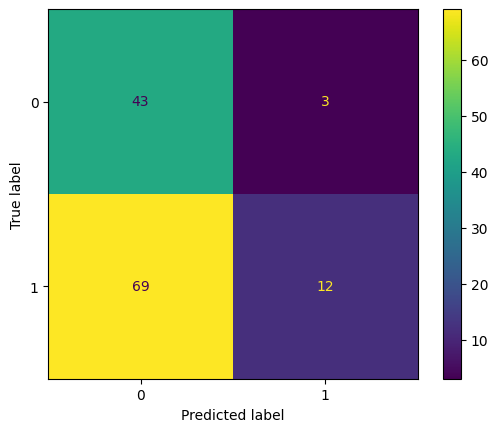

In [43]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay(confusion_matrix(df_filtered.encoded_labels, results))

disp.plot()


In [ ]:
# from google.colab import drive

# # Mount Google Drive
# drive.mount('/content/drive')

In [44]:
results = []

file_path = '/political_tendence_test2.csv'
# Initialize tqdm with the total number of rows in your dataframe
for i, row in tqdm(df_filtered.iterrows(), total=len(df_filtered)):
    score = political_tendence2(row)

    # Save intermediate results

    if i%500 == 0 and i > 5:
      df2 = pd.DataFrame(results)
      df2.to_csv(file_path, index=False, header=True)


    # Assign political tendence

    if score > 0:
        results.append(1)
    elif score < 0:
        results.append(0)
    else:
        results.append(random.choice([0, 1]))

df2 = pd.DataFrame(results)
df2.to_csv(file_path, index=False, header=True)

 57%|█████▋    | 73/127 [01:54<01:16,  1.41s/it]

2024-03-06 20:52:14,927 Warning: An empty Sentence was created! Are there empty strings in your dataset?


100%|██████████| 127/127 [03:32<00:00,  1.67s/it]


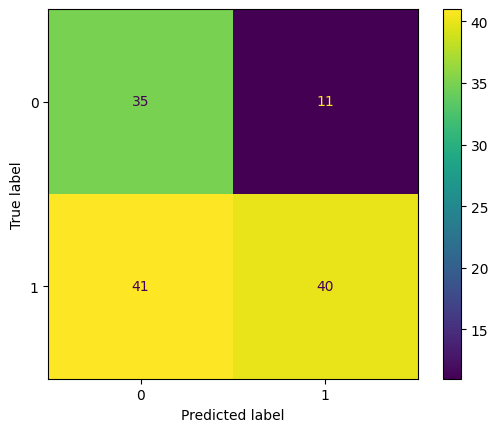

In [45]:


disp = ConfusionMatrixDisplay(confusion_matrix(df_filtered.encoded_labels, results))

disp.plot()


In [46]:

# Calculate evaluation metrics
accuracy = accuracy_score(df_filtered['encoded_labels'], results)
precision = precision_score(df_filtered['encoded_labels'], results, average='weighted', zero_division=0)
recall = recall_score(df_filtered['encoded_labels'], results, average='weighted', zero_division=0)
f1 = f1_score(df_filtered['encoded_labels'], results, average='weighted', zero_division=0)

# Print metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)


Accuracy: 0.5905511811023622
Precision: 0.6670363959922966
Recall: 0.5905511811023622
F1-score: 0.5943649741248812


Final plots (Poll results and Predicted results)

In [47]:
## Poll results

data = [
    ["Oct 24 2023", 34.2, 44.6, "rest"],
    ["Nov 6 2023", 44.6, 42.9, "rest"],
    ["Nov 9 2023", 48.6, 44.6, "rest"],
    ["Nov 19 2023", 55.65, 44.35, 0]
]


df = pd.DataFrame(data, columns=["Date", "Milei", "Massa", "Other"])


df['Date'] = pd.to_datetime(df['Date'])

# Calcular el restante
df['Rest'] = 100 - df[['Milei', 'Massa']].sum(axis=1)

df['Milei_prop'] = df['Milei'] / (df['Milei'] + df['Massa']) * 100
df['Massa_prop'] = df['Massa'] / (df['Milei'] + df['Massa']) * 100

In [50]:

import plotly.graph_objects as go



dfr = pd.read_csv("df_scores_final.csv")

# Drop rows with error
dfr = dfr[dfr['pro'] != 3]

dfr['date'] = pd.to_datetime(dfr['date'], errors='coerce')

dfr = dfr.dropna(subset=['date'])


# Convert to datetime
dfr['date'] = pd.to_datetime(dfr['date']).dt.date
dfr = dfr[dfr['date'] >= pd.to_datetime('2023-10-20')]


tweet_percentages = dfr.groupby('date')['pro'].value_counts(normalize=True).unstack().fillna(0) * 100

# Plot
fig = go.Figure()

# Models

fig.add_trace(go.Scatter(x=tweet_percentages.index, y=tweet_percentages[0], mode='lines+markers', name='Massa'))
fig.add_trace(go.Scatter(x=tweet_percentages.index, y=tweet_percentages[1], mode='lines+markers', name='Milei'))

# Poll + Final results

fig.add_trace(go.Scatter(x=df['Date'], y=df['Milei_prop'], mode='lines+markers', name='Milei Poll'))
fig.add_trace(go.Scatter(x=df['Date'], y=df['Massa_prop'], mode='lines+markers', name='Massa Poll'))
fig.update_layout(title='Percentage of Tweets for Massa and Milei',
                  xaxis_title='Date',
                  yaxis_title='Percentage of Tweets')

fig.show()

<ipython-input-50-e79eee669145>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfr['date'] = pd.to_datetime(dfr['date'], errors='coerce')
<ipython-input-50-e79eee669145>:19: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  dfr = dfr[dfr['date'] >= pd.to_datetime('2023-10-20')]
